---
<center>

  # **Tarea 07: Efecto Zeeman**

**Realizado Por:**

   Samuel Huertas Rojas

---
</center>

# 1 
Cálcule el efecto Zeeman para el átomo de hidrógeno usando un método variacional. Utilice como base los autoestados del átomo de hidrógeno no relativista para $n=2$ y $\ell=1$ y 100 valores de $B$ entre $0.001$ y $2$ Teslas

Tenemos que el hamiltoniano para el átomo de hidrogeno en un campo magnetico sería el siguiente:

$$
\hat{H} = \dfrac{\hat{p}}{2m} - \dfrac{Ze^2}{r} + \xi(r)(\hat{L}\cdot\hat{S}) +\mu_B B(\hat{L}_z + 2 \hat{S}_z)
$$

Desarrollandolo en la base $\ket{m_l, m_s}$, tenemos:

In [1]:
import itertools
import functools as ft
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
from sympy.physics.quantum.state import OrthogonalKet
from sympy.physics.quantum import TensorProduct

from sympy.physics.quantum.cg import CG
from sympy.physics.hydrogen import E_nl, R_nl

In [2]:
factor_conversion = {
    "cm": 219474.63137,
    "eV": 27.2114,
    "tesla": 235051.755,
    "joul": 4.3598e-18,
}

# Constantes a utilizar
alpha = 1 / 137.035999
c = 1 / alpha

mu = 1
me = 1
e = 1
Z = 1

# Números cuanticos
n = 2
l = 1  # noqa: E741
s = 1 / 2

In [3]:
# Valores simbolicos
Ket = OrthogonalKet

hbar = sp.symbols("hbar", real=True)
r, thet, phi = sp.symbols("r theta phi", real=True)


In [4]:
# Construcción de la base a utilizar
base_s = [Ket(s, ms) for ms in np.arange(s, -s - 1, -1)]
base_l = [Ket(l, ml) for ml in np.arange(l, -l - 1, -1)]


In [5]:
# Construcción del hamiltoniano sin perturbar
identidad = sp.eye(len(base_s) * len(base_l))
H0 = E_nl(n) * identidad
H0

Matrix([
[-1/8,    0,    0,    0,    0,    0],
[   0, -1/8,    0,    0,    0,    0],
[   0,    0, -1/8,    0,    0,    0],
[   0,    0,    0, -1/8,    0,    0],
[   0,    0,    0,    0, -1/8,    0],
[   0,    0,    0,    0,    0, -1/8]])

Para la construcción del producto punto entre $\hat{L} \cdot \hat{S} = \hat{L}_z\hat{S}_z + \dfrac{1}{2} \left( \hat{L}_+\hat{S}_- + \hat{L}_-\hat{S}_+ \right) $

In [6]:
# Generación de la matriz para cada uno de los operadores
def Jz(bases):
    identidad = sp.eye(len(bases))
    matriz_Jz = sp.Matrix([])
    for i in range(len(bases)):
        base = bases[i]

        j, m = base.label

        elemento = hbar * m
        matriz_Jz = matriz_Jz.col_insert(n, elemento * identidad.col(i))

    return matriz_Jz


def Jpm(signo, bases):
    Jpm = [[0 for i in range(len(bases))] for j in range(len(bases))]

    for i in range(len(bases)):
        for j in range(len(bases)):
            bra = bases[i].dual  # noqa: F841
            q, m = bases[j].label

            elemento = eval(
                "hbar*sp.sqrt(q*(q + 1) - m*(m {} 1))*(bra*Ket(q, m {} 1)).doit()".format(
                    signo,
                    signo,
                )
            )
            Jpm[i][j] = elemento

    matriz_Jpm = sp.Matrix(Jpm)

    return matriz_Jpm

In [7]:
Jp_matriz = ft.partial(Jpm, "+")
Jm_matriz = ft.partial(Jpm, "-")

Sz, Lz = Jz(base_s), Jz(base_l)
Sp, Sm = Jp_matriz(base_s), Jm_matriz(base_s)
Lp, Lm = Jp_matriz(base_l), Jm_matriz(base_l)

LzSz = TensorProduct(Lz, Sz)
LpSm = TensorProduct(Lp, Sm)
LmSp = TensorProduct(Lm, Sp)

LS = LzSz + 1 / 2 * (LpSm + LmSp)
LS

Matrix([
[0.5*hbar**2,                   0,                   0,                   0,                   0,           0],
[          0,        -0.5*hbar**2, 0.5*sqrt(2)*hbar**2,                   0,                   0,           0],
[          0, 0.5*sqrt(2)*hbar**2,                   0,                   0,                   0,           0],
[          0,                   0,                   0,                   0, 0.5*sqrt(2)*hbar**2,           0],
[          0,                   0,                   0, 0.5*sqrt(2)*hbar**2,        -0.5*hbar**2,           0],
[          0,                   0,                   0,                   0,                   0, 0.5*hbar**2]])

In [ ]:
def valor_esperado_eta(n, l):  # noqa: E741
    psi_conjugado = sp.conjugate(R_nl(n, l, r))

    V = lambda F: 1 / (2 * me**2 * c**2) * (Z * e**2 / r**3) * F  # noqa: E731

    eta_psi = V(R_nl(n, l, r))

    return sp.integrate(psi_conjugado * eta_psi * r**2, (r, 0, sp.oo))


valor_eta = ft.partial(valor_esperado_eta)

# Valor del hamiltoniano pertubardo
H1 = valor_eta(n, l) * LS

print(
    "{:.4f} 1/cm".format(
        list((H1.eigenvals()).keys())[0].n().subs(hbar, 1) * factor_conversion["cm"]
    )
)


0.1217 1/cm


In [ ]:
# Calculo de la perturbación del hamiltoniano dado por el campo mágnetico
def perturbacion_magnetico(B):
    # Magneton de Bohr muB = e * hbar / 2 * me
    muB = e * hbar / 2 * me

    H2_matriz = [
        [0 for i in range(len(base_l) * len(base_s))]
        for j in range(len(base_l) * len(base_s))
    ]

    k = 0

    for i in range(len(base_l)):
        l, ml = base_l[i].label  # noqa: E741
        for j in range(len(base_s)):
            s, ms = base_s[j].label

            H2_matriz[k][k] = muB * hbar * B * (ml + 2 * ms)

            k += 1

    return sp.Matrix(H2_matriz)


B = 0.1 / factor_conversion["tesla"]
H2 = perturbacion_magnetico(B)
H2

Matrix([
[4.25438218914809e-7*hbar**2, 0,                           0,                            0, 0,                            0],
[                          0, 0,                           0,                            0, 0,                            0],
[                          0, 0, 2.12719109457404e-7*hbar**2,                            0, 0,                            0],
[                          0, 0,                           0, -2.12719109457404e-7*hbar**2, 0,                            0],
[                          0, 0,                           0,                            0, 0,                            0],
[                          0, 0,                           0,                            0, 0, -4.25438218914809e-7*hbar**2]])

In [10]:
# Calculo total del hamiltoniano
H_total = H0 + H1 + H2
H_total.subs(hbar, 1).n()

Matrix([
[-0.124999019860171,                   0,                   0,                   0,                   0,                  0],
[                 0,   -0.12500055470161, 7.84466540311033e-7,                   0,                   0,                  0],
[                 0, 7.84466540311033e-7,  -0.124999787280891,                   0,                   0,                  0],
[                 0,                   0,                   0,  -0.125000212719109, 7.84466540311033e-7,                  0],
[                 0,                   0,                   0, 7.84466540311033e-7,   -0.12500055470161,                  0],
[                 0,                   0,                   0,                   0,                   0, -0.124999870736609]])

In [ ]:
# Obtener los autovalores del hamiltoniano
autovalores = ((H_total - H0) * factor_conversion["cm"]).subs(hbar, 1).eigenvals()
autovalores

{0.215115827700926: 1,
 -0.229191479344842: 1,
 0.154134996044472: 1,
 0.0919983960799398: 1,
 -0.260427775647347: 1,
 0.0283700351668518: 1}

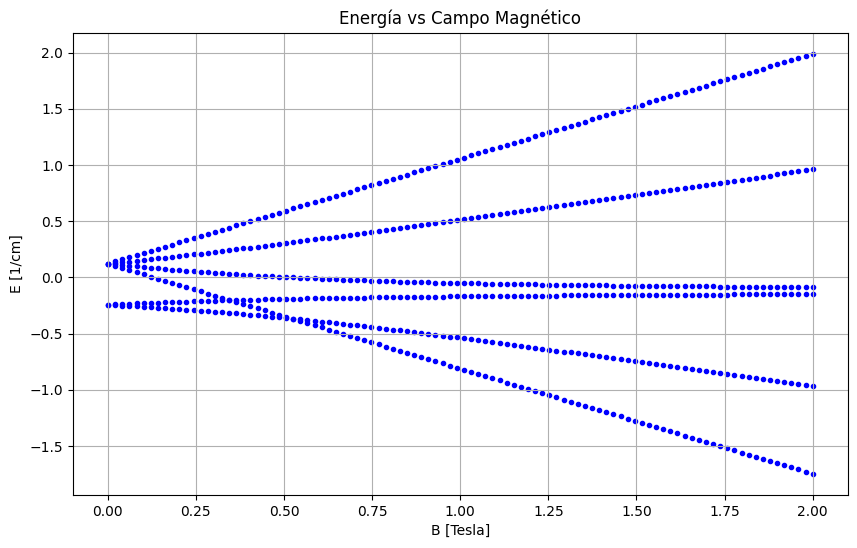

In [ ]:
# Grafica de los splittings del atomo de hidrogeno
valores_campo_magnetico = np.linspace(0.001, 2, 100)

puntos = []

for B in valores_campo_magnetico:
    H2 = perturbacion_magnetico(B / factor_conversion["tesla"])
    H = H0 + H1 + H2
    autovalores = ((H - H0) * factor_conversion["cm"]).subs(hbar, 1).eigenvals().keys()
    puntos.append(list(autovalores))

puntos = np.transpose(np.array(puntos))

plt.figure(figsize=(10, 6))

for y in puntos:
    plt.scatter(valores_campo_magnetico, y, color="blue", marker=".")

plt.title("Energía vs Campo Magnético")
plt.xlabel("B [Tesla]")
plt.ylabel("E [1/cm]")
plt.grid()
plt.show()

# 2
Compare las soluciones perturbativas con el método variacional para $B=0.04$ y $5$ Teslas de nuevo para $n=2$, $\ell=1$

Para utilizar el método  variacional 

In [ ]:
J = list(np.arange(abs(l - s), l + s + 1))
J

[np.float64(0.5), np.float64(1.5)]

In [ ]:
def E1(j):
    return (
        l != 0
        and hbar**2 / 2 * (j * (j + 1) - l * (l + 1) - s * (s + 1)) * valor_eta(n, l)
        or 0
    )


# Metodo variacional para la parte magnetica
def variacional_E2(B, j, mj):
    matriz_j = list(np.arange(-j, j + 1))  # noqa: F841
    mb = e * hbar / (2 * me)

    sum = 0
    for ket_l, ket_s in itertools.product(base_l, base_s):
        l, ml = ket_l.label  # noqa: E741
        s, ms = ket_s.label

        sum += ms * sp.Abs(CG(l, ml, s, ms, j, mj).doit()) ** 2

    elemento_E2 = mb * B * hbar * (mj + sum)

    return elemento_E2


# Calculo del campo magnetico para B =0.004 T
B = 0.004 / factor_conversion["tesla"]


def energia_total_variacional(j, mj):
    E = E_nl(n) + E1(j) + variacional_E2(B, j, mj)
    return E


lista_energia_B_perturbativo = []

for i in J:
    matriz_J = list(np.arange(-i, i + 1))
    for mj in matriz_J:
        energia = energia_total_variacional(i, mj) - E_nl(n)
        lista_energia_B_perturbativo.append(
            energia.subs(hbar, 1).n() * factor_conversion["cm"]
        )

lista_energia_B_perturbativo.sort()
lista_energia_B_perturbativo


[-0.244108348842891,
 -0.242863376892664,
 0.118008015583207,
 0.120497959483662,
 0.122987903384116,
 0.125477847284570]

In [ ]:
H2 = perturbacion_magnetico(0.04 / factor_conversion["tesla"])
H = H0 + H1 + H2
lista_energia_B_variacional = list(
    ((H - H0) * factor_conversion["cm"]).subs(hbar, 1).eigenvals().keys()
)
lista_energia_B_variacional.sort()

In [16]:
lista_energia_B_variacional

[-0.249926461798891,
 -0.237469519785670,
 0.0843937729270740,
 0.109508951111595,
 0.134401167605188,
 0.159092089940704]

In [17]:
# Calcular el error entre ambas listas
def calcular_error(lista1, lista2):
    errores = []
    print("Calculando errores...")
    for e1, e2 in zip(lista1, lista2):
        error = abs(e1 - e2)
        errores.append(error)
        print(f"Error entre {e1:.4f} y {e2:.4f} es {error:.6f}")

In [18]:
calcular_error(lista_energia_B_perturbativo, lista_energia_B_variacional)

Calculando errores...
Error entre -0.2441 y -0.2499 es 0.005818
Error entre -0.2429 y -0.2375 es 0.005394
Error entre 0.1180 y 0.0844 es 0.033614
Error entre 0.1205 y 0.1095 es 0.010989
Error entre 0.1230 y 0.1344 es 0.011413
Error entre 0.1255 y 0.1591 es 0.033614


In [ ]:
# Calcular para B = 5
H2 = perturbacion_magnetico(5 / factor_conversion["tesla"])
H = H0 + H1 + H2
lista_energia_B_variacional = list(
    ((H - H0) * factor_conversion["cm"]).subs(hbar, 1).eigenvals().keys()
)
lista_energia_B_variacional.sort()

In [20]:
lista_energia_B_variacional

[-4.54690188191796,
 -2.34763959395034,
 -0.133753374119195,
 -0.108425744159471,
 2.34633284936123,
 4.79038774478574]

Para campos magneticos fuertes tenemos que: 

$$
E_n = E - \mu_B B_z (ml + 2 ms)
$$

In [ ]:
def E1_campos_fuertes(B, ml, ms):
    muB = e * hbar / (2 * me)
    return muB * B * hbar * (ml + 2 * ms)


def E2_campos_fuertes(ml, ms):
    return l != 0 and hbar**2 * ml * ms * valor_eta(n, l) or 0


def Et(ml, ms):
    return E_nl(n) + E1_campos_fuertes(B, ml, ms) + E2_campos_fuertes(ml, ms)


# Calculo para el campo
B = 5 / factor_conversion["tesla"]

lista_energia_B_campos_fuertes = []

for ket_l, ket_s in itertools.product(base_l, base_s):
    l, ml = ket_l.label  # noqa: E741
    s, ms = ket_s.label

    valor = (Et(ml, ms) - E_nl(n)).n().subs(hbar, 1) * factor_conversion["cm"]

    lista_energia_B_campos_fuertes.append(valor)

lista_energia_B_campos_fuertes.sort()
lista_energia_B_campos_fuertes

[-4.54690188191796,
 -2.33432240667593,
 -0.121742931433889,
 -0.121742931433889,
 2.33432240667593,
 4.79038774478574]

In [22]:
calcular_error(lista_energia_B_campos_fuertes, lista_energia_B_variacional)

Calculando errores...
Error entre -4.5469 y -4.5469 es 0.000000
Error entre -2.3343 y -2.3476 es 0.013317
Error entre -0.1217 y -0.1338 es 0.012010
Error entre -0.1217 y -0.1084 es 0.013317
Error entre 2.3343 y 2.3463 es 0.012010
Error entre 4.7904 y 4.7904 es 0.000000


# 3
Incluya el segundo orden para la perturbación de $SO$ y compruebe cómo se mejora el resuldato de la aproximación de Paschen-Back para $B=5$ Teslas

In [ ]:
# Asumimos que las celdas del ejercicio anterior han sido ejecutadas.
from sympy.physics.quantum import qapply

def productoTensorial_Bases(bases_l, bases_s):
    lista_bases = []

    for ket_l, ket_s in itertools.product(bases_l, bases_s):
        l, ml = ket_l.label  # noqa: E741
        s, ms = ket_s.label

        lista_bases.append(Ket(ml, ms))

    return lista_bases


def matriz_LS(bra, ket, l, s):  # noqa: E741
    # Notemos que usando esta función, junto basis_tensorProduct se puede construir la matriz LS del ejercicio 1.

    def Npm(sign, j, mj):
        return eval("sp.sqrt(j*(j + 1) - mj*(mj {} 1))".format(sign))

    ml_p, ms_p = bra.label
    ml, ms = ket.label

    return hbar**2 * (
        ml * ms * qapply(bra * ket).doit()
        + 1 / 2
        * (
            Npm("+", l, ml) * Npm("-", s, ms) * qapply(bra * Ket(ml + 1, ms - 1)).doit()
            + Npm("-", l, ml)
            * Npm("+", s, ms)
            * qapply(bra * Ket(ml - 1, ms + 1)).doit()
        )
    )


def E22(ket):
    def E1_aux(ket):
        # Podiamos usar el E1 ya definido, pero como queremos hacerlo usando kets de la forma Ket(ml, ms), por tanto
        # tenemos que usar el elemento ket.label.

        ml, ms = ket.label

        muB = e * hbar / (2 * me)

        return muB * B * hbar * (ml + 2 * ms)

    basis = productoTensorial_Bases(base_l, base_s)

    ret = 0

    for bra in list(set(basis) - set([ket])):
        E1_b = E1_aux(bra)
        E1_k = E1_aux(ket)

        if E1_b == E1_k:
            continue

        ret += sp.Abs(matriz_LS(bra.dual, ket, l, s)) ** 2 / (E1_k - E1_b)

    ret *= sp.Abs(valor_eta(n, l)) ** 2

    return ret


def E_total_SO(ml, ms):
    return E_nl(n) + E1_campos_fuertes(B, ml, ms) + E2_campos_fuertes(ml, ms) + E22(Ket(ml, ms))


lista_energia_B_SO = []

for ket_l, ket_s in itertools.product(base_l, base_s):
    l, ml = ket_l.label  # noqa: E741
    s, ms = ket_s.label

    lista_energia_B_SO.append(
        (E_total_SO(ml, ms) - E_nl(n)).n().subs(hbar, 1) * factor_conversion["cm"]
    )

lista_energia_B_SO.sort()
lista_energia_B_SO

[-4.54690188191796,
 -2.34702103074921,
 -0.134441555507178,
 -0.109044307360600,
 2.34702103074921,
 4.79038774478574]

In [25]:
calcular_error(lista_energia_B_SO, lista_energia_B_variacional)

Calculando errores...
Error entre -4.5469 y -4.5469 es 0.000000
Error entre -2.3470 y -2.3476 es 0.000619
Error entre -0.1344 y -0.1338 es 0.000688
Error entre -0.1090 y -0.1084 es 0.000619
Error entre 2.3470 y 2.3463 es 0.000688
Error entre 4.7904 y 4.7904 es 0.000000
